# Task time predictions from RoboMission

Data source and explanation:
- https://github.com/adaptive-learning/adaptive-learning-research/tree/master/data/robomission-2019-02-09

## Basic info
- Users solve tasks, predict the time to solve: Log of `time_spent` in `task_sessions.csv`.
- metric: RMSE

## Approach
1. Baseline 1: global mean
2. Baseline 2: Mean per task
3. Baseline 3: Mean per user
4. ML 1: Basic Random Forest on `task.csv`, feature importances 
4. Time series prediction
    - first task solved after a long break?
    - school situation: just before the bell rings? morning/afternoon?
5. Prediction based on user types clustering - school kid / late (maybe teacher / self-study) / outliers

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt

In [3]:
PATH = "robomission-2019-02-09"

df_tasks = pd.read_csv(f"{PATH}/tasks.csv", parse_dates=True, low_memory=False)
df_sess = pd.read_csv(f"{PATH}/task_sessions.csv", parse_dates=True, low_memory=False)

In [4]:
display(df_tasks.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 9 columns):
id            85 non-null int64
name          85 non-null object
setting       85 non-null object
solution      85 non-null object
level1        85 non-null int64
level2        85 non-null int64
order         85 non-null int64
problemset    85 non-null int64
ps_order      85 non-null int64
dtypes: int64(6), object(3)
memory usage: 6.1+ KB


None

In [5]:
display(df_sess.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85416 entries, 0 to 85415
Data columns (total 11 columns):
id            85416 non-null int64
student       85416 non-null int64
task          85416 non-null int64
start         85416 non-null object
end           85416 non-null object
solved        85416 non-null bool
time_spent    85416 non-null int64
edits         85416 non-null int64
executions    85416 non-null int64
program       82935 non-null object
version       85416 non-null float64
dtypes: bool(1), float64(1), int64(6), object(3)
memory usage: 6.6+ MB


None

In [6]:
display(df_tasks.head(5))

id                    name  \
0  51     three-steps-forward   
1  49           turning-right   
2  44            turning-left   
3  26  turning-right-and-left   
4   2  turning-left-and-right   

                                             setting solution  level1  level2  \
0  {"fields": "b|b|b|b|b;k|k|k|k|k;k|k|k|k|k;k|k|...      fff       1       1   
1  {"fields": "b|bM|b|b|bM;kA|k|kM|k|kA;k|kM|kA|k...      rff       1       2   
2  {"fields": "bM|b|b|bM|b;kA|k|kM|k|kA;k|k|kA|kM...      lff       1       2   
3  {"fields": "b|bM|b|bM|bA;k|kA|kA|k|kM;kA|kM|k|...      frl       1       2   
4  {"fields": "b|bM|b|bM|b;kM|kA|k|kA|k;kA|k|kA|k...      lrf       1       2   

   order  problemset  ps_order  
0      1        1011         1  
1      1        1012         2  
2      2        1012         2  
3      3        1012         2  
4      4        1012         2

In [7]:
df_sess.head()

id  student  task                        start  \
0  39      917    26  2017-11-13T10:58:19.666306Z   
1  28      584    41  2017-11-12T08:57:39.741460Z   
2  13       29     8  2017-11-10T12:24:07.602156Z   
3  16      584     2  2017-11-12T08:33:42.535936Z   
4   4       29     2  2017-11-10T12:20:05.152265Z   

                           end  solved  time_spent  edits  executions  \
0  2017-11-13T10:59:21.969801Z   False          62      0           6   
1  2017-11-12T08:58:43.087657Z    True          63      6           1   
2  2017-11-10T12:24:24.986604Z    True          17      5           1   
3  2017-11-12T08:36:08.303324Z    True         145      3           2   
4  2017-11-10T12:20:29.837257Z    True          24      3           2   

       program  version  
0          NaN      1.0  
1  Wy{r}W!b{f}      1.0  
2        rssff      1.0  
3          lrf      1.0  
4          lrf      1.0

Get rid of entries where solved is false? What's the percentage?

In [8]:
df_sess[df_sess['solved'] == False].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10177 entries, 0 to 85415
Data columns (total 11 columns):
id            10177 non-null int64
student       10177 non-null int64
task          10177 non-null int64
start         10177 non-null object
end           10177 non-null object
solved        10177 non-null bool
time_spent    10177 non-null int64
edits         10177 non-null int64
executions    10177 non-null int64
program       7697 non-null object
version       10177 non-null float64
dtypes: bool(1), float64(1), int64(6), object(3)
memory usage: 884.5+ KB


1/8-th of the dataset. Let's remove the entries at least for the baselines.

## Baseline 1: Global mean
1. Split into train-test
2. Calculate the mean on the train dataset
3. Evaluate with RMSE on the testing one

In [9]:
from sklearn.model_selection import train_test_split

X = df_sess[df_sess['solved'] == True]
X = X.drop(['time_spent'], axis=1)

y = df_sess[df_sess['solved'] == True]
y = y[["time_spent"]]
y.time_spent = np.log(y.time_spent)

X_train, X_test, y_train, y_test = train_test_split(X, y["time_spent"], test_size=0.2, shuffle=False)

display(y_train.describe(include="all"))

global_mean_log_time_spent = y_train.describe(include="all")["mean"]
print(f"Global mean of log(time_spent): {global_mean_log_time_spent}")

count    60191.000000
mean         4.099144
std          1.165177
min          0.693147
25%          3.218876
50%          3.988984
75%          4.787492
max         12.476523
Name: time_spent, dtype: float64

Global mean of log(time_spent): 4.099143530210463


In [10]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())
#global_mean_baseline = [sum(x) for x in X_train.time_spent]
print(f"1. Baseline [training] RMSE score: {rmse(y_train.values, global_mean_log_time_spent)}")
print(f"1. Baseline [testing] RMSE score: {rmse(y_test.values, global_mean_log_time_spent)}")

1. Baseline [training] RMSE score: 1.165167686003262
1. Baseline [testing] RMSE score: 1.1401658935853862


## Baseline 2: Mean per task
1. Split into train-test
2. Calculate the mean per item on the train dataset
3. Evaluate with RMSE on the testing one

Task 25 doesn't have any records (its mean is nan)

In [11]:
X = df_sess[df_sess['solved'] == True]
X['time_spent_log'] = np.log(X['time_spent'])
df_sess_size = X.count()['id']
X_train = X[:int(df_sess_size*0.8)]
X_test = X[int(df_sess_size*0.8):]

/home/xslanin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [12]:
time_spent_per_task = {}
for task_no in list(X_train["task"].unique()):
    time_spent_per_task[task_no] = X_train[X_train["task"] == task_no]["time_spent_log"].mean()

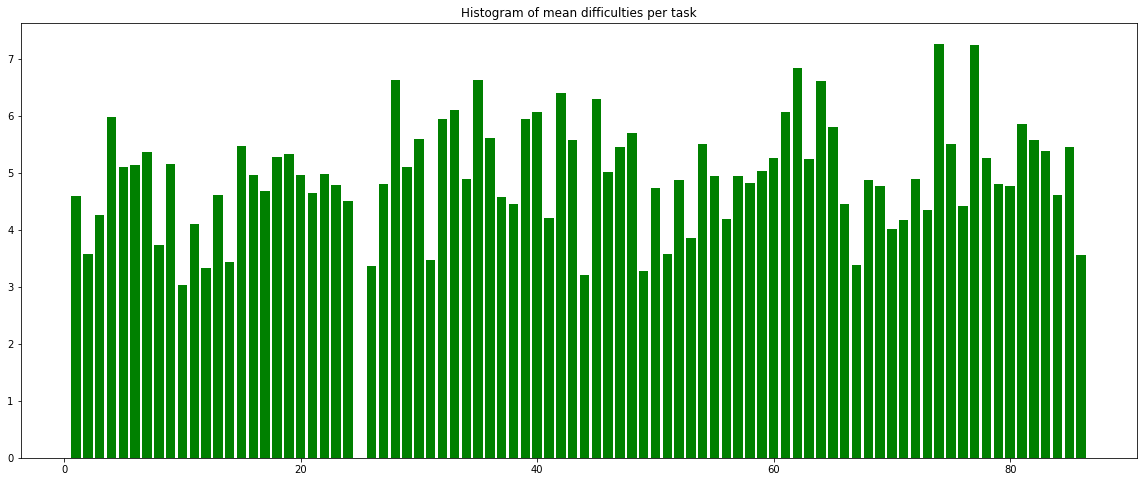

In [13]:
plt.figure(figsize=(20,8))
plt.bar(list(time_spent_per_task.keys()), time_spent_per_task.values(), color='g')
plt.title("Histogram of mean difficulties per task")
plt.show()

In [14]:
s = [(w,time_spent_per_task[w]) for w in sorted(time_spent_per_task, key=time_spent_per_task.get, reverse=True)]
s[:8]

[(74, 7.266336488942906),
 (77, 7.2468265088890185),
 (62, 6.835591380191274),
 (35, 6.632161293598834),
 (28, 6.630669940594158),
 (64, 6.605537827233863),
 (42, 6.402982765758398),
 (45, 6.303057211973832)]

In [15]:
rmse_per_task_train = []; rmse_per_task_test = []
for task_no in list(X_train["task"].unique()):
    rmse_per_task_train.append(rmse(X_train[X_train["task"] == task_no]["time_spent_log"].values, time_spent_per_task[task_no]))
    test_rmse = rmse(X_test[X_test["task"] == task_no]["time_spent_log"].values, time_spent_per_task[task_no])
    if not str(test_rmse) == "nan":
        rmse_per_task_test.append(test_rmse)

print(f"2. Baseline [training] RMSE score: {np.array(rmse_per_task_train).mean()}")
print(f"2. Baseline [testing] RMSE score: {np.array(rmse_per_task_test).mean()}")

2. Baseline [training] RMSE score: 1.052729053825909
2. Baseline [testing] RMSE score: 0.9800111898625438


/home/xslanin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice.
  """Entry point for launching an IPython kernel.
/home/xslanin/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Baseline 2: Mean per user
1. Split into train-test
2. Calculate the mean per user on the train dataset
3. Evaluate with RMSE on the testing one

In [16]:
print(f"There are {len(X_train['student'].unique())} users")

There are 4273 users


In [17]:
time_spent_per_user = {}
for student_no in list(X_train["student"].unique()):
    time_spent_per_user[student_no] = X_train[X_train["student"] == student_no]["time_spent_log"].mean()

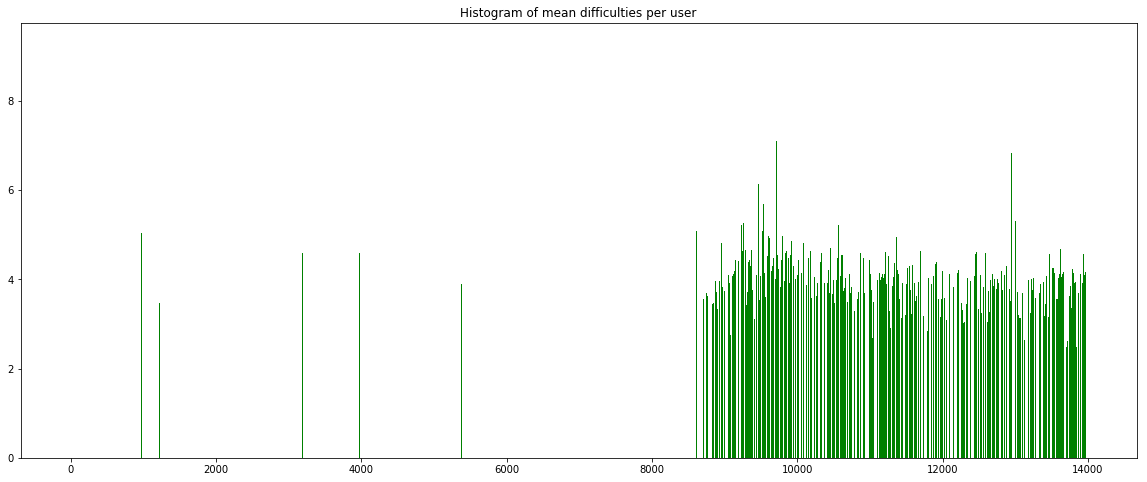

In [18]:
plt.figure(figsize=(20,8))
plt.bar(list(time_spent_per_user.keys()), time_spent_per_user.values(), color='g')
plt.title("Histogram of mean difficulties per user")
plt.show()

In [19]:
rmse_per_user_train = []; rmse_per_user_test = []
for student_no in list(X_train["student"].unique()):
    rmse_per_user_train.append(rmse(X_train[X_train["student"] == student_no]["time_spent_log"].values, time_spent_per_user[student_no]))
    test_rmse = rmse(X_test[X_test["student"] == student_no]["time_spent_log"].values, time_spent_per_user[student_no])
    if not str(test_rmse) == "nan":
        rmse_per_user_test.append(test_rmse)

print(f"3. Baseline [training] RMSE score: {np.array(rmse_per_user_train).mean()}")
print(f"3. Baseline [testing] RMSE score: {np.array(rmse_per_user_test).mean()}")

/home/xslanin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice.
  """Entry point for launching an IPython kernel.


3. Baseline [training] RMSE score: 0.8547223547464807
3. Baseline [testing] RMSE score: 1.3208606846158215


In [20]:
unique, counts = np.unique(np.array(rmse_per_user_train), return_counts=True)
# unique[0], counts[0]
print(f"There's only 1 task solved for {counts[0]} users (in train), which results in corresponding rmse being 0, which minimizes the overall mean rmse")
unique, counts = np.unique(np.array(rmse_per_user_test), return_counts=True)
print(f"There's only 1 task solved for {counts[0]} users (in test), which results in corresponding rmse being 0, which minimizes the overall mean rmse")

There's only 1 task solved for 397 users (in train), which results in corresponding rmse being 0, which minimizes the overall mean rmse
There's only 1 task solved for 1 users (in test), which results in corresponding rmse being 0, which minimizes the overall mean rmse


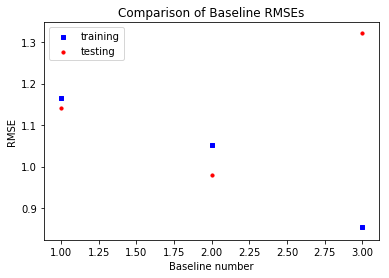

In [21]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_title("Comparison of Baseline RMSEs")
ax1.scatter([1, 2, 3], [rmse(y_train.values, global_mean_log_time_spent), np.array(rmse_per_task_train).mean(), np.array(rmse_per_user_train).mean()], s=10, c='b', marker="s", label='training')
ax1.scatter([1, 2, 3], [rmse(y_test.values, global_mean_log_time_spent), np.array(rmse_per_task_test).mean(), np.array(rmse_per_user_test).mean()], s=10, c='r', marker="o", label='testing')
ax1.set_xlabel("Baseline number"); ax1.set_ylabel("RMSE")
plt.legend(loc='upper left');
plt.show()

## ML 1: Basic Random Forest
1. Split into train-test
2. Run RF
3. Evaluate feature importances

In [22]:
X = df_sess[df_sess['solved'] == True]
X = X.drop(['time_spent'], axis=1)

y = df_sess[df_sess['solved'] == True]
y = y[["time_spent"]]
y.time_spent = np.log(y.time_spent)

X_train, X_valid, y_train, y_valid = train_test_split(X, y["time_spent"], test_size=0.2, shuffle=False)

In [25]:
df_sess.head(5)

id  student  task                        start  \
0  39      917    26  2017-11-13T10:58:19.666306Z   
1  28      584    41  2017-11-12T08:57:39.741460Z   
2  13       29     8  2017-11-10T12:24:07.602156Z   
3  16      584     2  2017-11-12T08:33:42.535936Z   
4   4       29     2  2017-11-10T12:20:05.152265Z   

                           end  solved  time_spent  edits  executions  \
0  2017-11-13T10:59:21.969801Z   False          62      0           6   
1  2017-11-12T08:58:43.087657Z    True          63      6           1   
2  2017-11-10T12:24:24.986604Z    True          17      5           1   
3  2017-11-12T08:36:08.303324Z    True         145      3           2   
4  2017-11-10T12:20:29.837257Z    True          24      3           2   

       program  version  
0          NaN      1.0  
1  Wy{r}W!b{f}      1.0  
2        rssff      1.0  
3          lrf      1.0  
4          lrf      1.0

In [24]:
from sklearn.ensemble import RandomForestRegressor

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
          m.score(X_train, y_train), m.score(X_valid, y_valid)]
    return res

m = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m.fit(X_train, y)
print(f"{m.oob_score_}")
print_score(m)

/home/xslanin/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ValueError: could not convert string to float: '2017-11-12T08:57:39.741460Z'

AttributeError: 'RandomForestRegressor' object has no attribute 'oob_score_'